In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage as skm

from kedro.extras.datasets.pickle import PickleDataSet

In [ ]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.pipelines.data_processing.nodes import prepare_input
from tagseg.data.acdc_dataset import AcdcDataSet

In [3]:
dataset = PickleDataSet(filepath='../data/03_primary/acdc_train.pt').load()

In [4]:
transformation_params = dict(perform=True, generator_model='../data/06_models/netG_A2B.pth', batch_size=16)

tagged = prepare_input(dataset, transformation_params)

100%|██████████| 115/115 [00:48<00:00,  2.38it/s]


In [7]:
examples, labels = dataset.tensors
t_examples, t_labels = tagged.tensors

In [73]:
idx = 170

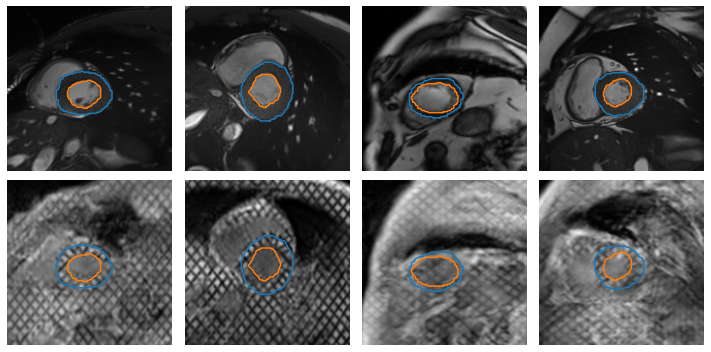

In [81]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for n, i in enumerate([12, 171, 25, 75]):

    ax[0, n].imshow(examples[i, 0], cmap='gray')
    ax[0, n].axis('off')

    ax[1, n].imshow(t_examples[i, 0], cmap='gray')
    ax[1, n].axis('off')

    contours = skm.measure.find_contours(labels[i].numpy())

    for contour in contours:
        ax[0, n].plot(*contour[:, ::-1].T)
        ax[1, n].plot(*contour[:, ::-1].T)

    cx, cy = contours[1].mean(axis=0)
    padding = 80

    for x in ax:
        x[n].set_xlim(cx - padding, cx + padding)
        x[n].set_ylim(cy + padding, cy - padding)

plt.tight_layout()
plt.show()